In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import normalize
from joblib import load

In [2]:
X, y = load('../../preprocessing/clustering_data.joblib')
X.head()

,Belts,PersonalInjury,PropertyDamage,CommercialLicense,CommercialVehicle,ContributedToAccident,Gender,VehicleType_'02 - Automobile',VehicleType_'03 - Station Wagon',VehicleType_'04 - Limousine',...,Model_VAN,Model_VERSA,Model_VN,Race_ASIAN,Race_BLACK,Race_HISPANIC,Race_OTHER,Race_WHITE,ArrestType_Marked Patrol,ArrestType_Unmarked Patrol
0,-0.188036,-0.107601,-0.14066,-0.173900,-0.069214,-0.156898,1.428003,0.361115,-0.129298,-0.023057,...,-0.133037,-0.10026,-0.139808,-0.250806,-0.679667,-0.521663,-0.236043,1.345395,0.431566,-0.225375
1,-0.188036,-0.107601,-0.14066,-0.173900,-0.069214,-0.156898,-0.700278,0.361115,-0.129298,-0.023057,...,-0.133037,-0.10026,-0.139808,-0.250806,-0.679667,-0.521663,4.236511,-0.743276,0.431566,-0.225375
2,-0.188036,-0.107601,-0.14066,-0.173900,-0.069214,-0.156898,-0.700278,0.361115,-0.129298,-0.023057,...,-0.133037,-0.10026,-0.139808,-0.250806,1.471309,-0.521663,-0.236043,-0.743276,-2.317144,4.437056
3,-0.188036,-0.107601,-0.14066,-0.173900,-0.069214,-0.156898,-0.700278,0.361115,-0.129298,-0.023057,...,-0.133037,-0.10026,-0.139808,-0.250806,1.471309,-0.521663,-0.236043,-0.743276,0.431566,-0.225375
4,-0.188036,-0.107601,-0.14066,5.750436,-0.069214,-0.156898,-0.700278,0.361115,-0.129298,-0.023057,...,-0.133037,-0.10026,-0.139808,-0.250806,-0.679667,-0.521663,-0.236043,1.345395,0.431566,-0.225375


Izvršićemo under sampling kako ne bi došlo do prekoračenja memorije. (Inače se javlja ovaj problem)

In [10]:
from collections import Counter
from imblearn.under_sampling import NearMiss
from numpy import where

undersample = NearMiss(version=1, n_neighbors=3)
X, y = undersample.fit_resample(X, y)

counter = Counter(y)
print(counter)

Counter({0: 3496, 1: 3496, 2: 3496})


In [11]:
X_norm = normalize(X)
X_norm_df = pd.DataFrame(X_norm)

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PCA 1', 'PCA 2'])

## Biramo najbolji model

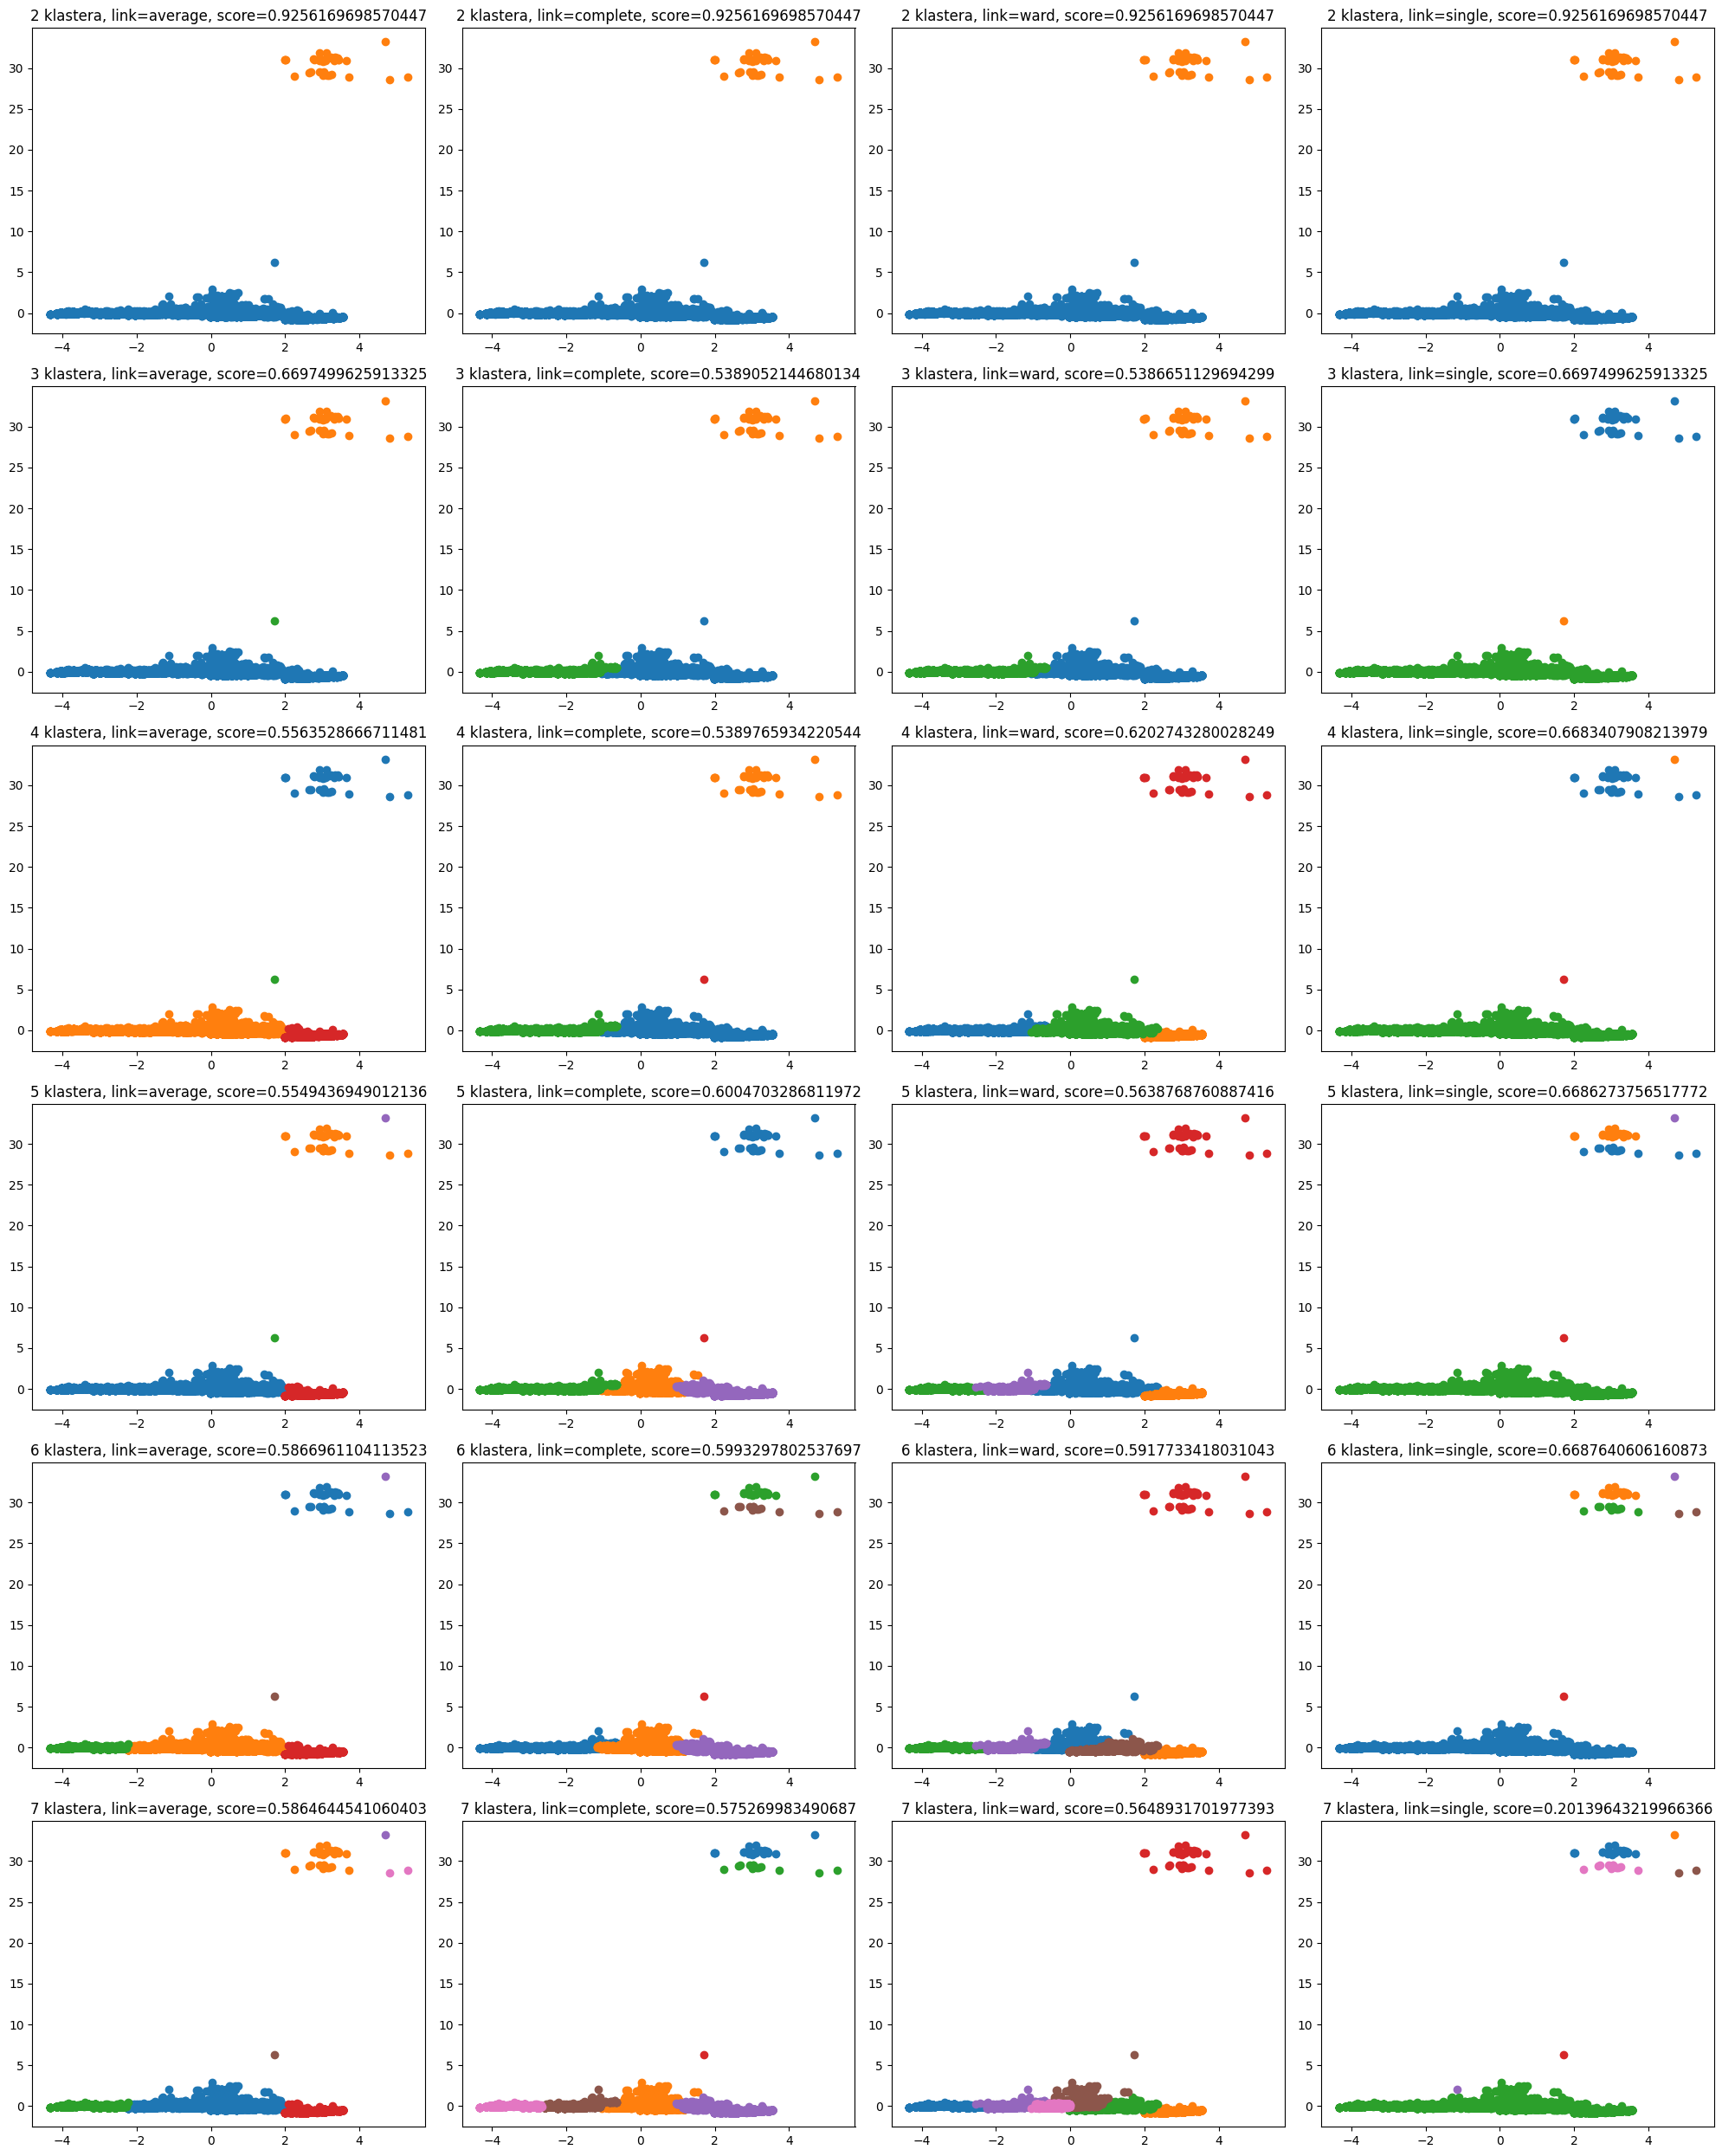

In [14]:
linkages = ['average', 'complete', 'ward', 'single']
cluster_range = range(2,8)
silhouettes = []
i = 1
best_model = None
max_score = float('-inf')
fig = plt.figure(figsize=(20,25))

for cluster_num in cluster_range:
    for l in linkages:
        model = AgglomerativeClustering(n_clusters=cluster_num, linkage=l)
        model.fit(X_pca_df)
           
        score = silhouette_score(X_pca_df, model.labels_)
        
        fig.add_subplot(len(cluster_range), len(linkages), i)
        i += 1
        
        for cluster_label in range(cluster_num):
            cluster = X_pca_df[cluster_label == model.labels_]
            plt.scatter(cluster['PCA 1'], cluster['PCA 2'], label=f'cluster {cluster_label}')
            
        plt.title(f'{cluster_num} klastera, link={l}, score={score}')
        if score > max_score:
            max_score = score
            best_model = model
            
        if best_model.linkage == l:
            silhouettes.append(silhouette_score(X_pca_df, model.labels_))


plt.tight_layout()
plt.show()

In [15]:
best_model.n_clusters_

2

In [16]:
max_score

0.9256169698570447

In [17]:
best_model.linkage

'average'

## Prikazujemo izdvojen najbolji model

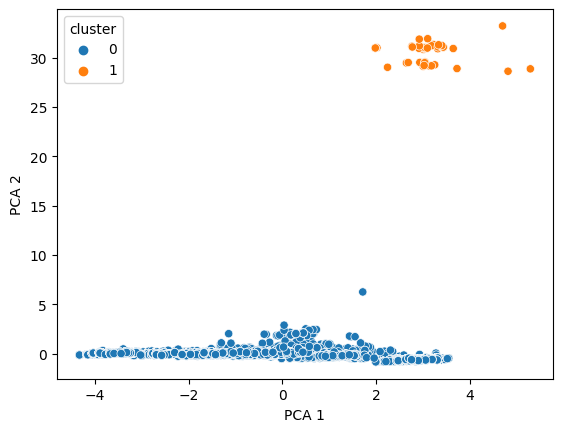

In [18]:
X_pca_df['cluster'] = pd.Categorical(best_model.labels_)
sns.scatterplot(x = "PCA 1", y = "PCA 2", hue = "cluster", data = X_pca_df)
plt.show()

In [19]:
silhouettes

[0.9256169698570447,
 0.6697499625913325,
 0.5563528666711481,
 0.5549436949012136,
 0.5866961104113523,
 0.5864644541060403]

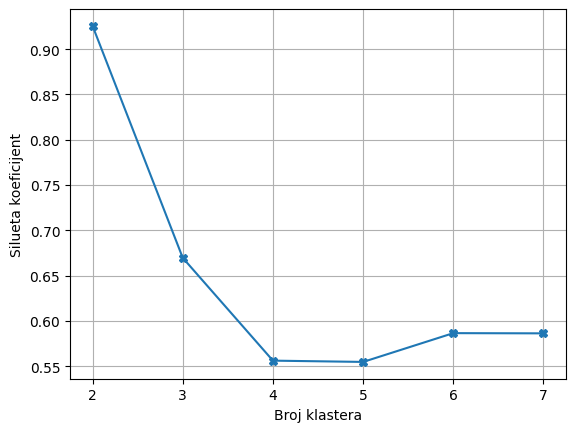

In [20]:
plt.plot(cluster_range, silhouettes, marker='X')
plt.grid()
plt.xlabel('Broj klastera')
plt.ylabel('Silueta koeficijent')
plt.show()

## Prikazujemo dendrogram

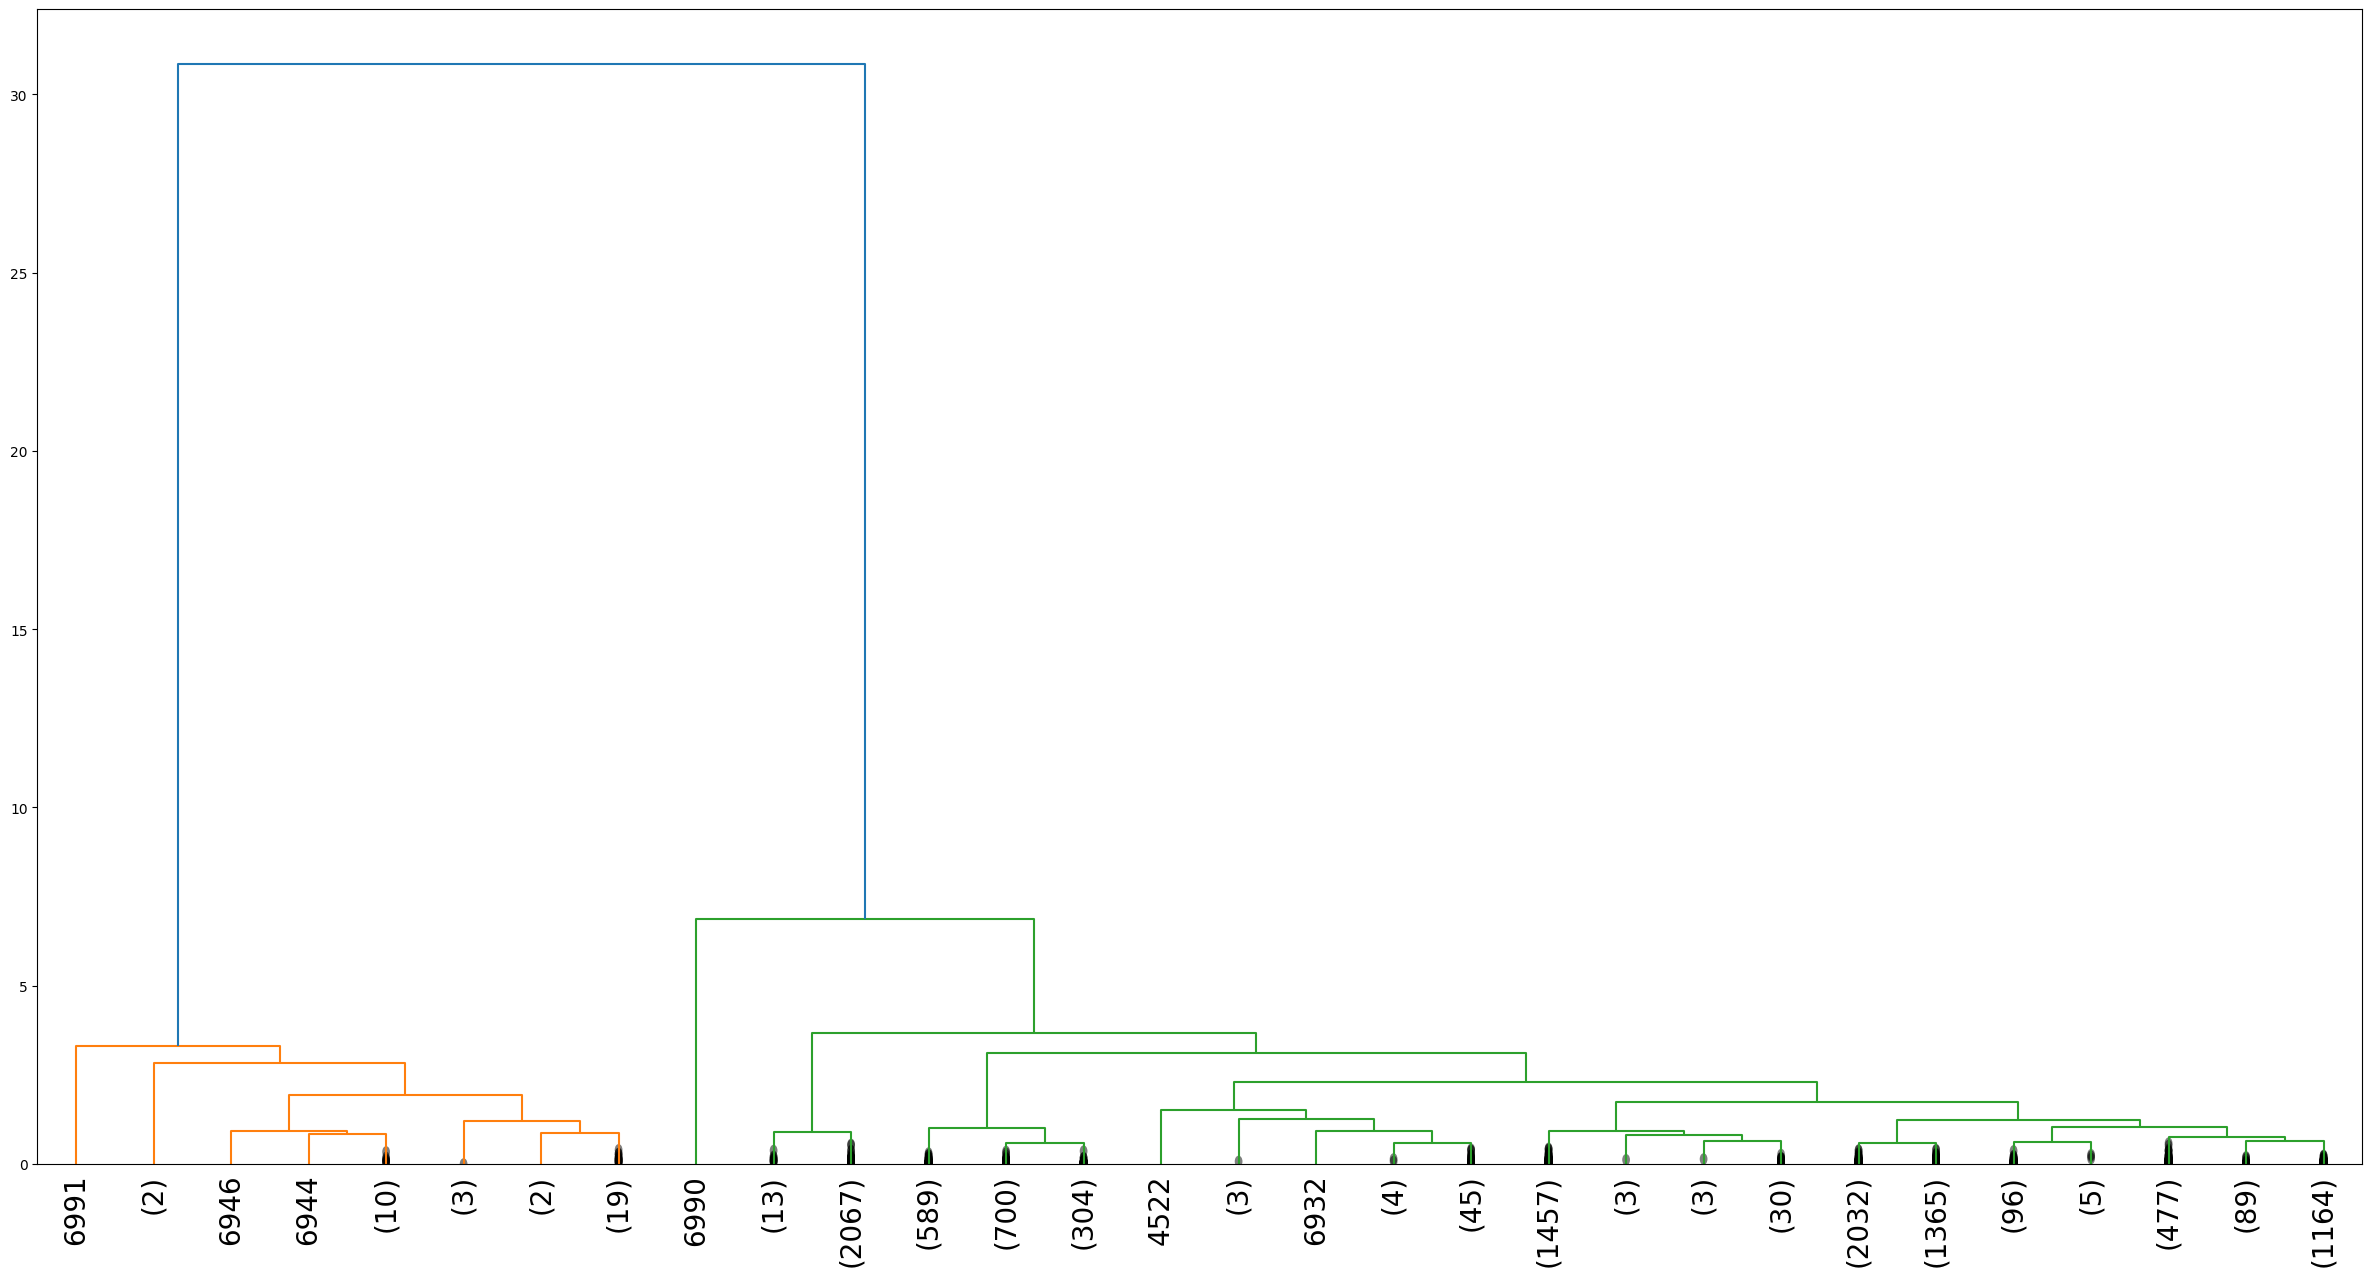

In [21]:
plt.figure(figsize=(30,15))

dendrogram(
    linkage(X_pca_df, method=best_model.linkage),
    truncate_mode='lastp',   
    labels=X_pca_df.index,
    leaf_rotation=90.,
    leaf_font_size=20,
    show_contracted=True, 
)

plt.show()